 Yet Another Titanic Dataset Analysis

In [34]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
%matplotlib inline

In [35]:
# get titanic & test csv files as a DataFrame
titanic_df = pd.read_csv("train.csv")
test_df    = pd.read_csv("test.csv")

# preview the data
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Passenger ID, name, and ticket will be dropped. Fare could be other candidate to be dropped (correlation with class), and perhaps cabin too. I'll initially assume that cabin doesn't help predict Survive, and let's first see what happens with fare and class.

In [36]:
train = titanic_df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
test    = test_df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
#We also add a 1/0 variable for Sex
df_sex=pd.get_dummies(train['Sex'],drop_first=True)
train=train.join(df_sex)

df_sex_2=pd.get_dummies(test['Sex'],drop_first=True)
test=test.join(df_sex_2)
#Also df['Gender'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)


#Dummies for Pclass too

df_pclass=pd.get_dummies(train['Pclass'],prefix='Class').astype(int)
train=train.join(df_pclass)

df_pclass_2=pd.get_dummies(test['Pclass'],prefix='Class').astype(int)
test=test.join(df_pclass_2)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,male,Class_1,Class_2,Class_3
0,0,3,male,22.0,1,0,7.2500,S,1,0,0,1
1,1,1,female,38.0,1,0,71.2833,C,0,1,0,0
2,1,3,female,26.0,0,0,7.9250,S,0,0,0,1
3,1,1,female,35.0,1,0,53.1000,S,0,1,0,0
4,0,3,male,35.0,0,0,8.0500,S,1,0,0,1


In [37]:
#Deal with age

avg_age_train=train['Age'].mean()
std_age_train=train['Age'].std()
nans_age_train=train['Age'].isnull().sum()

avg_age_test=test['Age'].mean()
std_age_test=test['Age'].std()
nans_age_test=test['Age'].isnull().sum()

#Generate random ages
rand_1 = np.random.randint(avg_age_train-std_age_train,avg_age_train+std_age_train,size=nans_age_train)
rand_2 = np.random.randint(avg_age_test-std_age_test,avg_age_test+std_age_test,size=nans_age_test)

#Fill NaNs
#train["Age"][np.isnan(train["Age"])] = rand_1
#test["Age"][np.isnan(test["Age"])] = rand_2
#Median better than mean to avoid outliers
train['Age'].fillna(train['Age'].median(), inplace=True)
test['Age'].fillna(test['Age'].median(), inplace=True)
#Check
np.all(~np.isnan(train["Age"]))

True

          Survived   Class_1   Class_2   Class_3     SibSp     Parch  \
Survived  1.000000  0.285904  0.093349 -0.322308 -0.035322  0.081629   
Class_1   0.285904  1.000000 -0.288585 -0.626738 -0.054582 -0.017633   
Class_2   0.093349 -0.288585  1.000000 -0.565210 -0.055932 -0.000734   
Class_3  -0.322308 -0.626738 -0.565210  1.000000  0.092548  0.015790   
SibSp    -0.035322 -0.054582 -0.055932  0.092548  1.000000  0.414838   
Parch     0.081629 -0.017633 -0.000734  0.015790  0.414838  1.000000   
Fare      0.257307  0.591711 -0.118557 -0.413333  0.159651  0.216225   
male     -0.543351 -0.098013 -0.064746  0.137143 -0.114631 -0.245489   
Age      -0.064910  0.323896  0.015831 -0.291955 -0.233296 -0.172482   

              Fare      male       Age  
Survived  0.257307 -0.543351 -0.064910  
Class_1   0.591711 -0.098013  0.323896  
Class_2  -0.118557 -0.064746  0.015831  
Class_3  -0.413333  0.137143 -0.291955  
SibSp     0.159651 -0.114631 -0.233296  
Parch     0.216225 -0.245489 -0.1

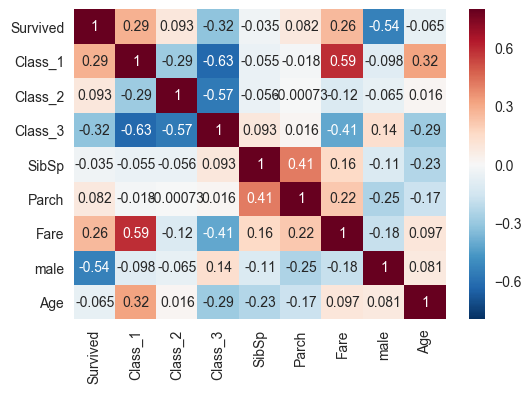

In [38]:
corrmat=train[['Survived','Class_1','Class_2','Class_3','SibSp','Parch','Fare','male','Age']].corr()
print(corrmat)
sns.heatmap(corrmat,vmax=.8,annot=True)

There doesn't seem to be NaNs or weird things, no need for cleaning. But we do need to fill some values for age. Also, I should check whether embarked does something. Let's go with that first. 

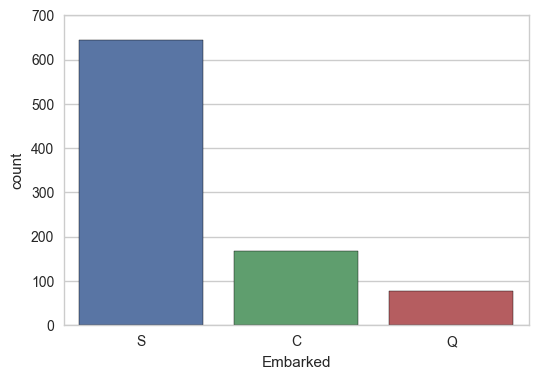

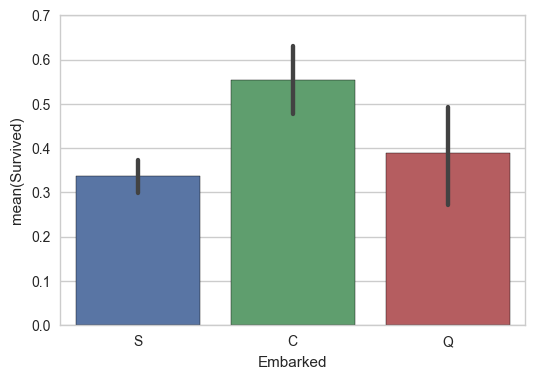

In [39]:
sns.countplot(x="Embarked", data=train);
plt.figure();
sns.barplot(x='Embarked',y="Survived", data=train);

But is this spurious due to higher variability in C and Q because there are less of them? Maybe. Perhaps it'd be worthwhile to keep these around, so let's dummy them, and run a regression.

It seems to make sense to impute the missing values to S, as it is the most common, and near the average

In [40]:
train['Embarked']=train['Embarked'].fillna('S')
test['Embarked']=test['Embarked'].fillna('S')

df_em=pd.get_dummies(train['Embarked'],prefix='Embarked')

Let's study the fare-class relationship

In [41]:
# First, I need to extract the fares and  group them by Pclass, then plot.
#pclass_fare=train[['Fare','Pclass']]
#print(pclass_fare.groupby(['Pclass']).describe())
#print(pclass_fare.groupby(['Pclass']).mean())
#sns.boxplot(x="Pclass", y="Fare", data=pclass_fare);

As expected, the correlation seems to be there. But how strong is the correlation?

Hm, perhaps better to keep it. $R^2$ is not that high

For fun, how are fares by Pclass distributed?

/home/artir/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


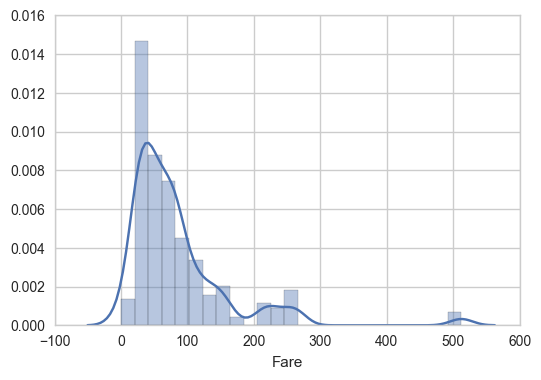

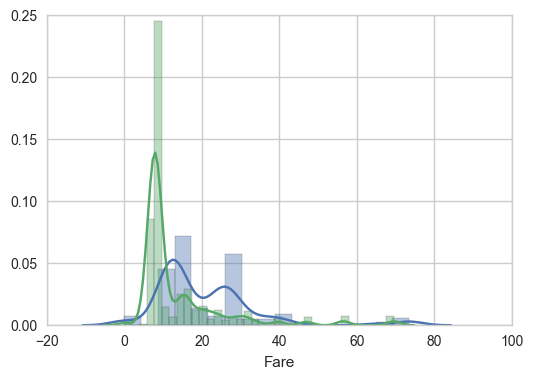

In [42]:
sns.distplot(train[train['Class_1']==1]['Fare'])
plt.figure()
sns.distplot(train[train['Class_2']==1]['Fare'])
sns.distplot(train[train['Class_3']==1]['Fare'])

Back to Embarked and survived:

In [43]:
# result = sm.ols(formula="Survived ~Embarked_Q+Embarked_C+Embarked_S ", data=train).fit()
# print(result.params)
# print (result.summary())
#R2 too small, disregard.

So finally, the choosen features will be Pclass, Fare, male, and age. Time to do some predictions.

In [44]:
# define training and testing sets
#There happens to be one missing element in Fare. So let's fix that
test["Fare"].fillna(test["Fare"].median(), inplace=True)
X_train = train[['Pclass','Fare','male','Age']]
Y_train = train[["Survived"]]
X_test  = test[['Pclass','Fare','male','Age']]

In [45]:
# Logistic Regression
# machine learning
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, Y_train.values.ravel())

Y_pred = logreg.predict(X_test)
logreg.score(X_train, Y_train)

0.7912457912457912

Let's add some more features

In [46]:
train['FamilySize'] = train['SibSp'] + train['Parch']
test['FamilySize'] = test['SibSp'] + test['Parch']

# If greater than zero, it'll be one. If not, zero
train['HaveFamily'] = 0
test['HaveFamily'] = 0
test['FamilySize'] = test['SibSp'] + test['Parch']
train['FamilySize'] = train['SibSp'] + train['Parch']

test.loc[test['FamilySize']>0,'HaveFamily']=1
train.loc[train['FamilySize']>0,'HaveFamily']=1

#Childs
train['child'] = 0
test['child'] = 0
test.loc[test['Age']<15,'child']=1
train.loc[train['Age']<15,'child']=1
predictors=['Parch','SibSp','Fare','male','Age','FamilySize','HaveFamily','Class_1','Class_2','Class_3','child']
X_train = train[predictors]

Y_train = train[["Survived"]]
X_test  = test[predictors]

               Parch     SibSp      Fare      male       Age  FamilySize  \
Parch       1.000000  0.414838  0.216225 -0.245489 -0.172482    0.783111   
SibSp       0.414838  1.000000  0.159651 -0.114631 -0.233296    0.890712   
Fare        0.216225  0.159651  1.000000 -0.182333  0.096688    0.217138   
male       -0.245489 -0.114631 -0.182333  1.000000  0.081163   -0.200988   
Age        -0.172482 -0.233296  0.096688  0.081163  1.000000   -0.245619   
FamilySize  0.783111  0.890712  0.217138 -0.200988 -0.245619    1.000000   
HaveFamily  0.583398  0.584471  0.271832 -0.303646 -0.171647    0.690922   
Class_1    -0.017633 -0.054582  0.591711 -0.098013  0.323896   -0.046114   
Class_2    -0.000734 -0.055932 -0.118557 -0.064746  0.015831   -0.038594   
Class_3     0.015790  0.092548 -0.413333  0.137143 -0.291955    0.071142   
child       0.361001  0.364654 -0.003117 -0.095692 -0.560466    0.429578   

            HaveFamily   Class_1   Class_2   Class_3     child  
Parch         0.583398

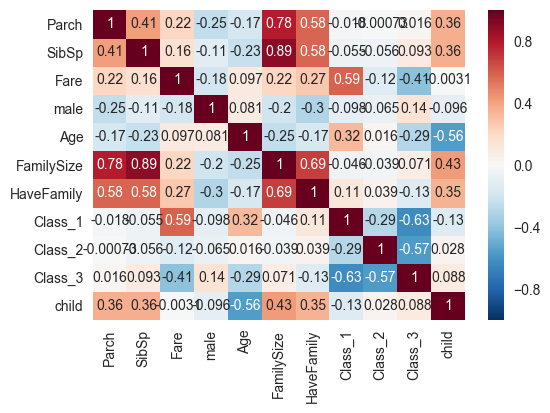

In [47]:
corrmat=train[predictors].corr()
print(corrmat)

a=sns.heatmap(corrmat,annot=True)

In [48]:
logreg = LogisticRegression()

logreg.fit(X_train, Y_train.values.ravel())

Y_pred = logreg.predict(X_test)
logreg.score(X_train, Y_train)

0.80920314253647585

Including the family bits and Class increases the score. (!) Guess it wasn't that good of an idea to disregard those at the beginning.
Let's now try a bunch of other methods.

In [49]:
# Import the random forest package
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import learning_curve


# Create the random forest object which will include all the parameters
# for the fit
forest=RandomForestClassifier(max_features='sqrt',max_depth=8,n_estimators=240)

# Fit the training data to the Survived labels and create the decision trees
forest.fit(X_train,Y_train.values.ravel())

# Take the same decision trees and run it on the test data
Y_pred = forest.predict(X_test)
forest.score(X_train, Y_train)
# What features are important?
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = forest.feature_importances_
features.sort(['importance'],ascending=False)

/home/artir/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,feature,importance
3,male,0.364375
2,Fare,0.201354
4,Age,0.154100
9,Class_3,0.075587
5,FamilySize,0.056493
7,Class_1,0.034916
1,SibSp,0.031640
10,child,0.028228
0,Parch,0.022727
8,Class_2,0.017080


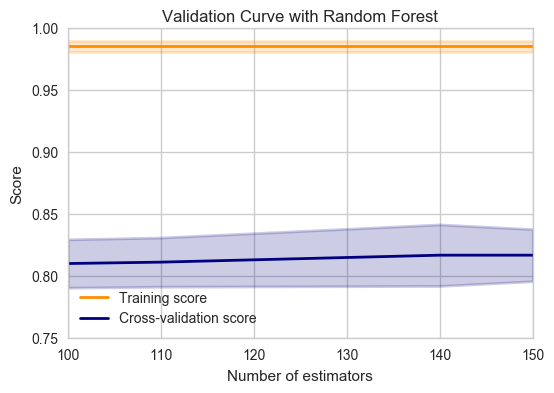

In [50]:
from sklearn.model_selection import validation_curve
X, y = X_train,Y_train['Survived']
#X, y = train_new,Y_train['Survived']
def cross_val(model,X,y,pname):
    param_range = np.array([100,110,140,150])
    train_scores, test_scores = validation_curve(
        model, X, y, param_name=pname, param_range=param_range, scoring="accuracy", n_jobs=4)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with Random Forest")
    plt.xlabel("Number of estimators")
    plt.ylabel("Score")
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
cross_val(RandomForestClassifier(),X,y,'n_estimators')

In [51]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



title = "Learning Curves (RandomForest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
#cv = ShuffleSplit(n_splits=20, test_size=0.33, random_state=0)

#estimator=RandomForestClassifier(n_estimators=100)
#plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)


Hmm, underfitting :/

The prediction seems good enough for now, let's submit'...

... Or maybe not. First public submission got 0.65. Time to try another method?

About 0.775 with RandomForests. One final trial, with XGBoost

In [52]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
# fit model no training data
model = XGBClassifier()
model_params = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100,150,200],
    'max_depth': [2, 3,7, 10],
}
cv = StratifiedKFold()
cv.get_n_splits(X_train,Y_train)
grid= GridSearchCV(model,model_params,scoring='roc_auc',cv=cv,verbose=2)
best_params={'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.05}
#grid.fit(X_train, Y_train.values.ravel())
model = XGBClassifier(n_estimators= 100, max_depth= 2, learning_rate= 0.05)
model.fit(X_train,Y_train.values.ravel())

# Take the same decision trees and run it on the test data
Y_pred = model.predict(X_test)
#Y_pred = [round(value) for value in Y_pred]

In [53]:
#cross_val(XGBClassifier(),X,y,'n_estimators')
#About 200 seems okay

<module 'matplotlib.pyplot' from '/home/artir/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

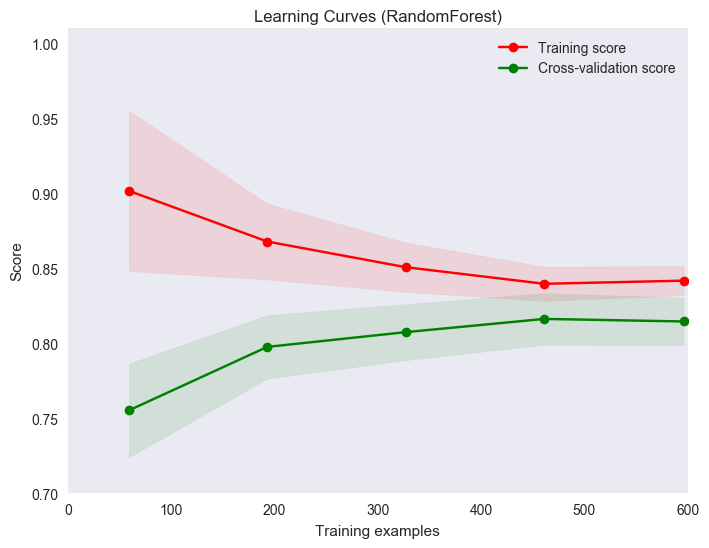

In [58]:
title = "Learning Curves (RandomForest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
mpl.rcParams['figure.figsize'] = [8.0, 6.0]

plot_learning_curve(model, title, X, y, ylim=(0.7, 1.01), cv=cv)

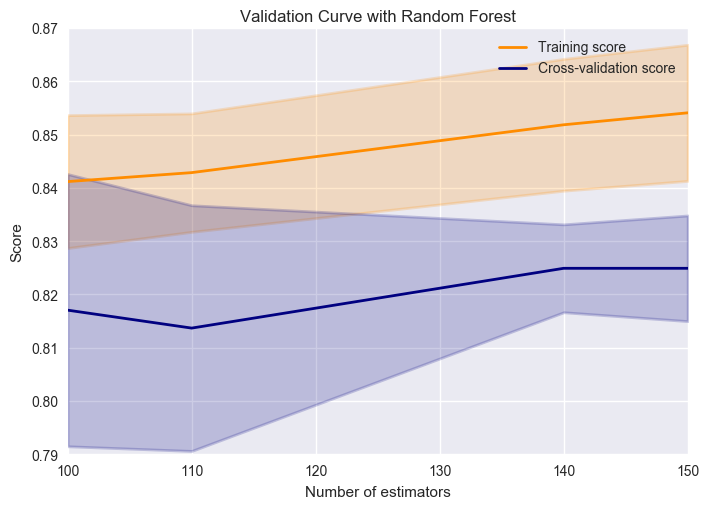

In [55]:
import matplotlib as mpl
sns.set()
cross_val(model,X,y,'n_estimators')

In [56]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,male,Class_1,Class_2,Class_3,FamilySize,HaveFamily,child
0,3,male,34.5,0,0,7.8292,Q,1,0,0,1,0,0,0
1,3,female,47.0,1,0,7.0000,S,0,0,0,1,1,1,0
2,2,male,62.0,0,0,9.6875,Q,1,0,1,0,0,0,0
3,3,male,27.0,0,0,8.6625,S,1,0,0,1,0,0,0
4,3,female,22.0,1,1,12.2875,S,0,0,0,1,2,1,0


In [57]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)

In [60]:
import sys
print(sys.version)

3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


# Lessons learned

1. Establishing a process for analysing the data is important, even if that process requires iteration
2. It really comes down to explore the data, generate features, then feed to the algorithm
3. Which algorithm? Apparently XGBoost is the best. Also, try neural nets with keras.
4. Correlation plots are interesting to heuristically decide what to keep/drop. In the end
5. Some plots are better than others, depending on the case